In [1]:
# ! pip install transformers -U
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# 第十五週 bert

利用bert model 進行傲慢與偏見 及 世界大戰 的分類

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from time import time  # To time our operations

from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
import torch

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

設定畫圖、及cuda使用的GPU

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# 設定畫圖背景樣式、調色盤樣式、字型大小
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
# 設定調色盤顏色
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
# 設定畫布大小
rcParams['figure.figsize'] = 12, 8

# 設定隨機變數
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
# 設定使用 GPU（第0張）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

讀入兩本書

In [4]:
tp = pd.read_csv('./raw_data/en_tp_clean.csv')
war = pd.read_csv('./raw_data/war_clean.csv')

In [5]:
# 合併書籍
tp.drop(columns="chapter", inplace=True)
tp['title'] = 'pride and prejudice'
war['title'] = 'The War of the Worlds'
books = pd.concat([tp,war],axis=0)
books.dropna(inplace=True)
books

,sentence,title
0,TPRIDE PREJUDICE,pride and prejudice
1,It is a truth universally acknowledged that a ...,pride and prejudice
2,However little known the feelings or views of ...,pride and prejudice
3,My dear Mr_Bennet said his lady to him one day...,pride and prejudice
4,Mr_Bennet replied that he had not,pride and prejudice
...,...,...
3218,general information project gutenbergtm electr...,The War of the Worlds
3219,forty years produced distributed project guten...,The War of the Worlds
3220,project gutenbergtm ebooks often created sever...,The War of the Worlds
3221,thus necessarily keep ebooks compliance partic...,The War of the Worlds


Text(0.5, 0, 'book')

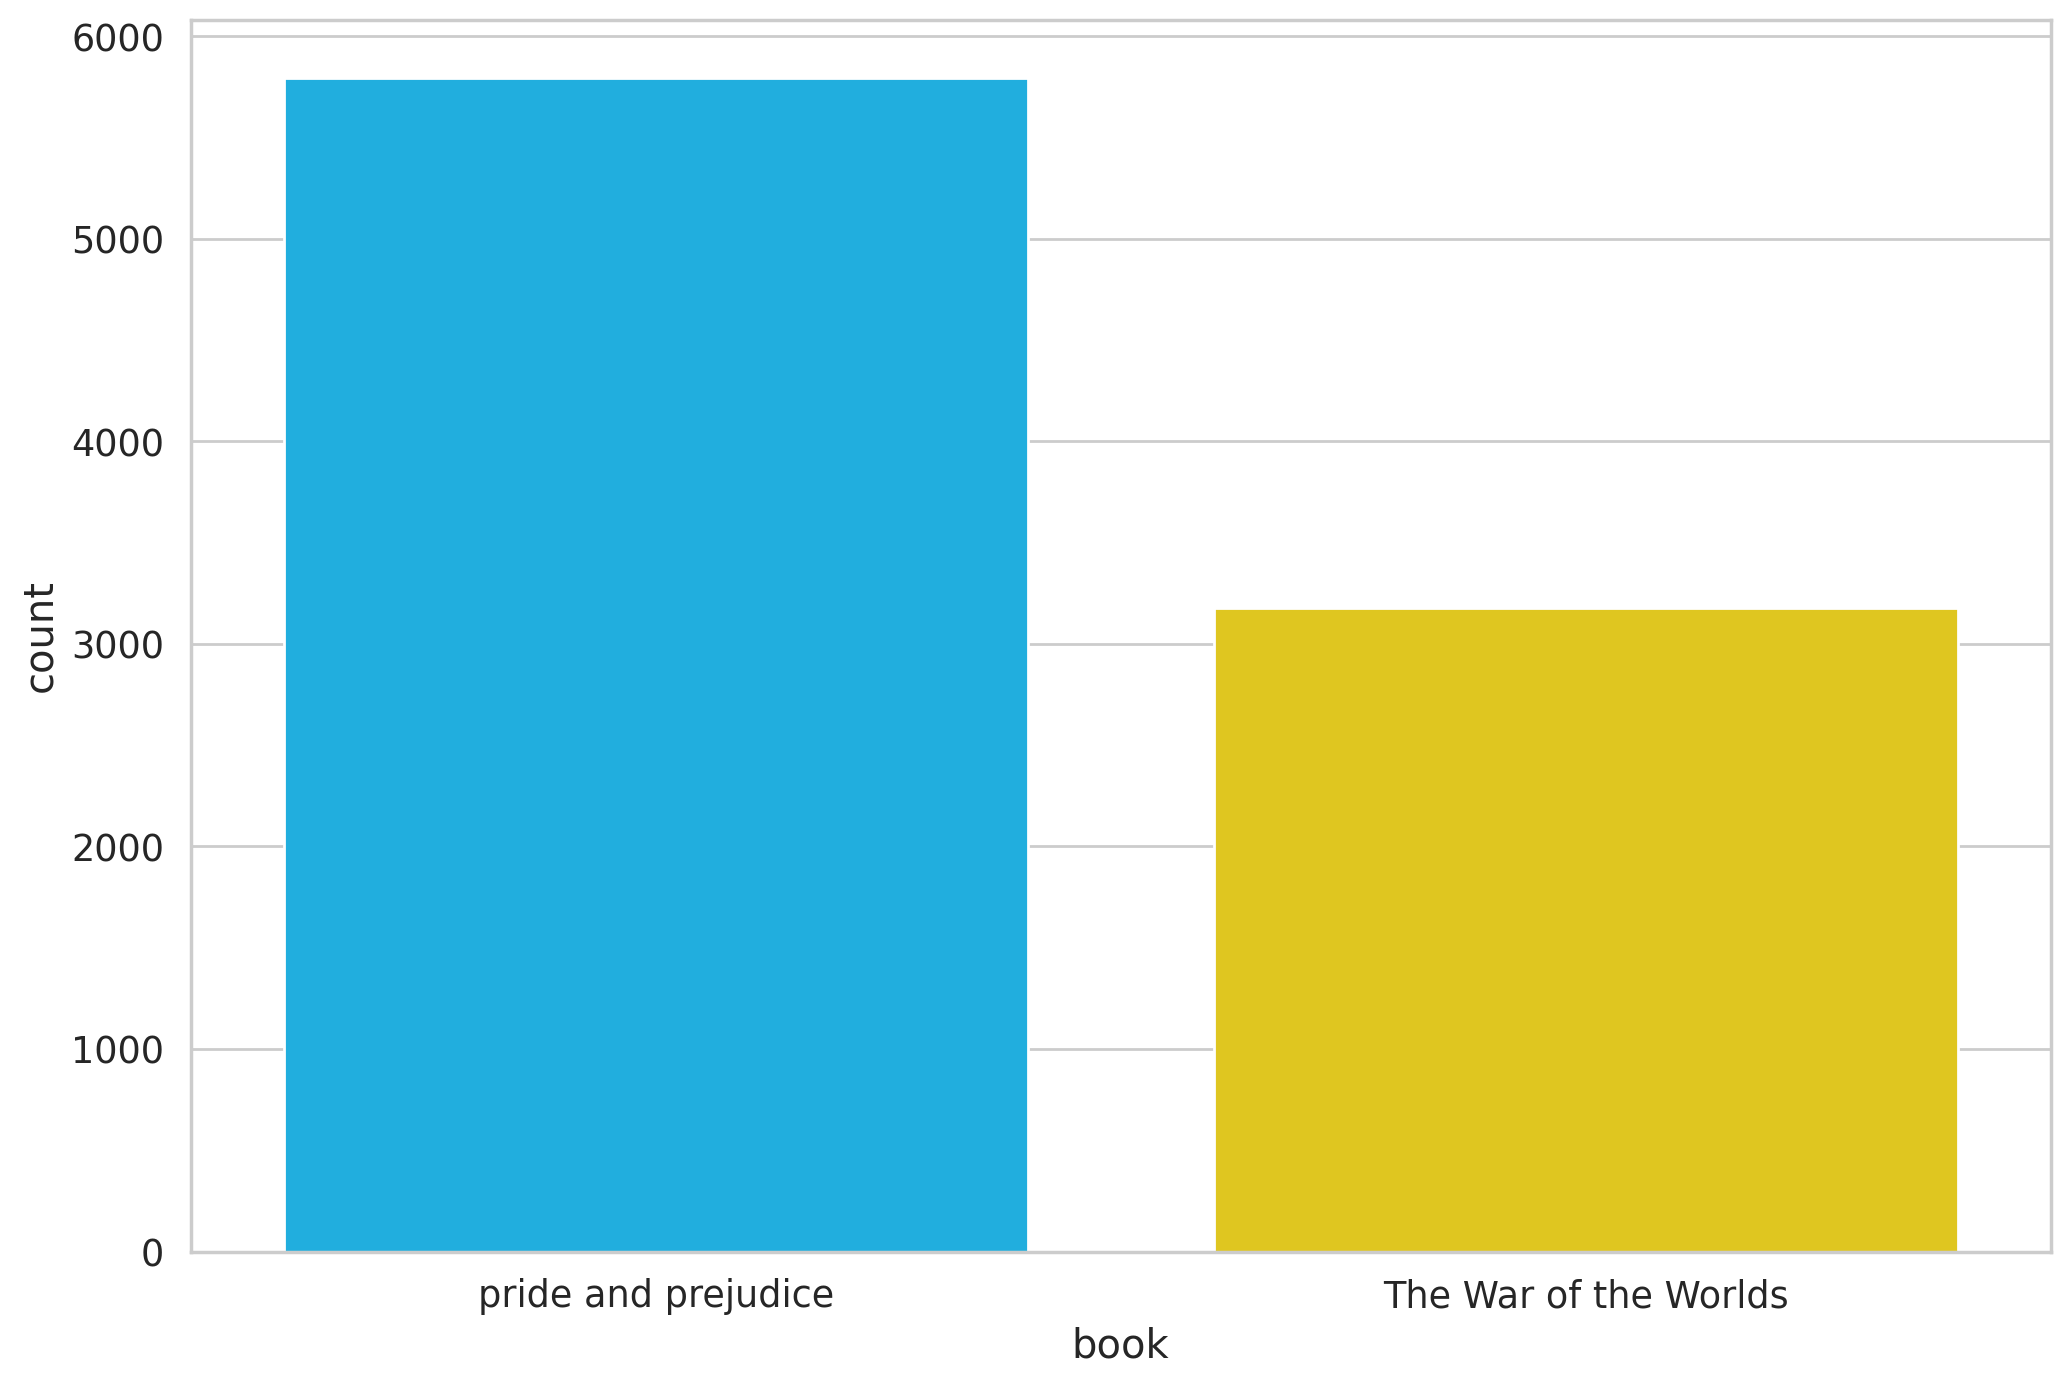

In [6]:
sns.countplot(books,x = 'title')
plt.xlabel('book')

In [7]:
# 將兩本書上label
book_map = {
    'pride and prejudice':0,
    'The War of the Worlds':1,
}

books['class'] = books.title.apply(lambda r: book_map[r])

In [8]:
# 設定pretrain的model
# bert-base-cased（區分大小寫，可以不用轉成lower）、bert-base-uncased（不能區分大小寫）、bert-base-chinese
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [9]:
sample_txt = 'My my dear friends. Together friends forever.' # 範例句子
tokens = tokenizer.tokenize(sample_txt) # 切開的詞
token_ids = tokenizer.convert_tokens_to_ids(tokens) # 詞的ID

print(f'Sentence: {sample_txt}\n')
print(f'Tokens: {tokens}')
print(f'Token IDs: {token_ids}\n')

# 查看tokenizer中的設定
print(f'start marker: {tokenizer.cls_token}, id {tokenizer.cls_token_id}')  # 句子的開頭
print(f'end marker: {tokenizer.sep_token}, id {tokenizer.sep_token_id}')  # 句子的結尾
print(f'padding marker: {tokenizer.pad_token}, id {tokenizer.pad_token_id}')  # padding
print(f'unknown marker: {tokenizer.unk_token}, id {tokenizer.unk_token_id}')  # 不知道的詞

Sentence: My my dear friends. Together friends forever.

Tokens: ['My', 'my', 'dear', 'friends', '.', 'Together', 'friends', 'forever', '.']
Token IDs: [1422, 1139, 7059, 2053, 119, 6333, 2053, 5221, 119]

start marker: [CLS], id 101
end marker: [SEP], id 102
padding marker: [PAD], id 0
unknown marker: [UNK], id 100


encode plus

可以拿到token的id 及他們的attention mask(PAD的地方會是0)

In [10]:
encoding = tokenizer.encode_plus(
  sample_txt, # 我們上面定義的句子
  max_length=32,# 一個句子的最大長度，如果超過就截斷，沒有則加上[PAD]補完
  padding='max_length', # padding的方式,max_length：表示padding到max_length
  truncation=True,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

# 可以將 encode 值取出來的key
print(f"type of encode: {type(encoding)}")
encoding.keys()


# 查看 encode之後的結果
print(f"{sample_txt}")
# encode後句子的長度
print(f"sentence length after encoding: {len(encoding['input_ids'][0])}\n") 

encode_token = tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]) # 將ID轉換回token
encode_tokenID = encoding['input_ids'][0]
encode_attention = encoding['attention_mask'][0]

print(f"encode tokens:\n {encode_token}") # encode後的 token 
print(f"encode token id:\n {encode_tokenID}") # encode後的 token ID
print(f"attention mask:\n {encode_attention}") # encode後的 attention mask

type of encode: <class 'transformers.tokenization_utils_base.BatchEncoding'>
My my dear friends. Together friends forever.
sentence length after encoding: 32

encode tokens:
 ['[CLS]', 'My', 'my', 'dear', 'friends', '.', 'Together', 'friends', 'forever', '.', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
encode token id:
 tensor([ 101, 1422, 1139, 7059, 2053,  119, 6333, 2053, 5221,  119,  102,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])
attention mask:
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


先簡單的把句子給斷開成tokens,再決定使用的長度

In [11]:
# 計算資料集中句子的長度
token_lens = [] # 存所有句子的長度
for txt in books.sentence:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True) # 將句子斷開，限定最大長度為512
    token_lens.append(len(tokens))

/tmp/ipykernel_1030976/86454686.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


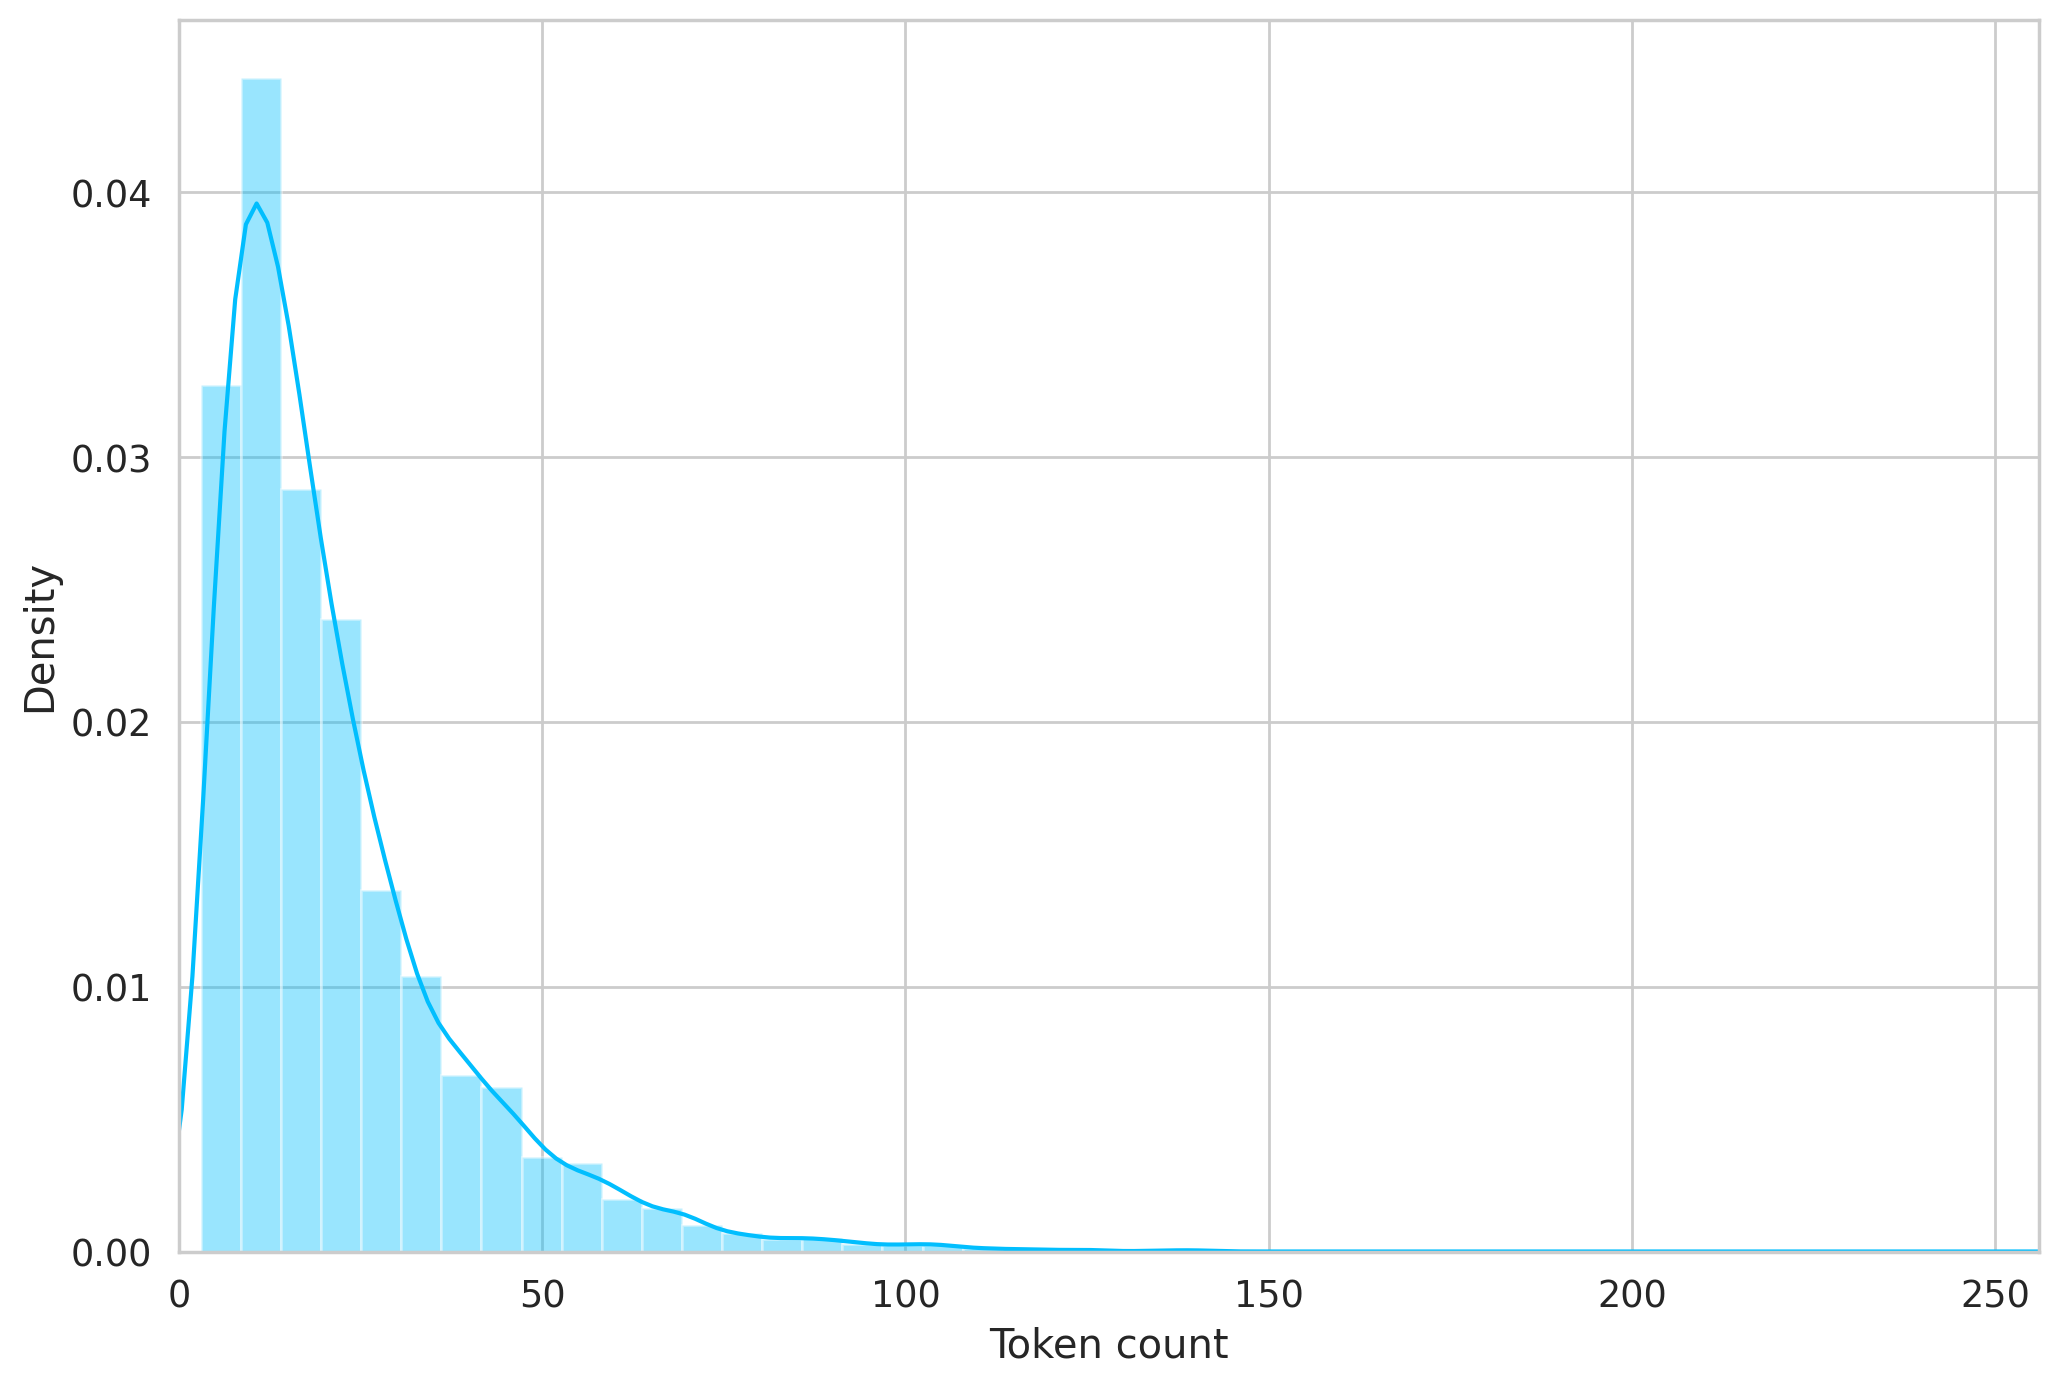

In [12]:
# 將句子長度的分布畫出來
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

分割資料集
切train、validation、test

In [13]:
# 先切出train
book_train, book_test = train_test_split(books, test_size=0.3, random_state=RANDOM_SEED)
# 在切出val、test
book_val, book_test = train_test_split(book_test, test_size=0.5, random_state=RANDOM_SEED)

In [14]:
# 看一下三種資料的總筆數
print("shape of train / validation / test")
print(book_train.shape, book_val.shape, book_test.shape)

shape of train / validation / test
(6278, 3) (1345, 3) (1346, 3)


打包資料集成dataload的結構，可以簡單地丟入模型

In [15]:
# 先將資料包成dataset
class DatasetForBert(Dataset):
    """
    input: 句子(sents)及label(targets)
    tokenizer: 進行句子斷句的parser
    max_len: 設定要的句子長度
    """
    def __init__(self, sents, targets, tokenizer, max_len):
        self.sents = sents
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.sents)
  
    def __getitem__(self, item):
        sents = str(self.sents[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          sents,
          truncation=True,
          add_special_tokens=True,
          max_length=self.max_len, #句子的最大長度
          padding='max_length',
          return_token_type_ids=False,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'sent_text': sents,
          'input_ids': encoding['input_ids'].flatten(), # encode 完之後的 token id
          'attention_mask': encoding['attention_mask'].flatten(), # encode 完之後的 attention mask
          'targets': torch.tensor(target, dtype=torch.long)
        }
# 利用dataloader，load資料進模型
def create_data_loader(sents, labels, tokenizer, max_len, batch_size):
    
    assert(len(sents) == len(labels))
    ds = DatasetForBert(
        sents=sents, # 要預測的句子
        targets=labels, # 要預測的目標
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

將切分的資料集打包成dataload

In [16]:
BATCH_SIZE = 16 
MAX_LEN = 150

# 處理 train / validation / test 的 data loader
train_data_loader = create_data_loader(book_train['sentence'].to_numpy(),book_train['class'].to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(book_val['sentence'].to_numpy(),book_val['class'].to_numpy(),tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(book_test['sentence'].to_numpy(),book_test['class'].to_numpy(), tokenizer, MAX_LEN, BATCH_SIZE)

In [17]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['sent_text', 'input_ids', 'attention_mask', 'targets'])

In [18]:
# sahpe = (BATCH_SIZE * MAX_LEN)
print(data['input_ids'].shape)
print(data['attention_mask'].shape)

# sahpe = BATCH_SIZE
print(data['targets'].shape)

torch.Size([16, 150])
torch.Size([16, 150])
torch.Size([16])


load 進bert的 pretrain model

In [19]:

# 載入bert的pretrain model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
# encode前面的例句，將前面的例句丟入 bert
bert_encode_output = bert_model(
    input_ids=encoding['input_ids'], 
    attention_mask=encoding['attention_mask']
)
# bert 用來代表每個字的維度
print(f"vector size: {bert_model.config.hidden_size}")  
# bert model 最後一層 layer output 的 sahpe (data_size * max_length * hidden_size)
print(f"shape of last output: {bert_encode_output.last_hidden_state.shape}")
# bert model 最後一層 layer 的 shape
print(f"shape of last layer: {bert_encode_output.pooler_output.shape}")  


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


vector size: 768
shape of last output: torch.Size([1, 32, 768])
shape of last layer: torch.Size([1, 768])


定義模型，使用pytorch 的 nn 框架

In [20]:
class SentClassifier(nn.Module):

    def __init__(self, n_classes, drop = 0.5):
        """
        n_class :分類的個數，例如：binary(true/false) n_classes = 2

        """
        super(SentClassifier, self).__init__()
        # 定義會用到的方法
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME) #bert model
        self.drop = nn.Dropout(p=drop) # dropout layer
        # 拿output的hidden vector 進行預測 ，weight會是 hidden_size＊n_classes
        # 最後output的維度會是跟n_classe一樣
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes) # layer sahpe, 預測幾類
  
    def forward(self, input_ids, attention_mask):
        # model input 進去的是句子的token id 及需要attention 的位置
        model_output = self.bert( 
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        output = self.drop(model_output.pooler_output)
        return self.out(output)

In [21]:
model = SentClassifier(len(books['class'].unique()))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


訓練前也需要將data放進GPU

In [22]:

input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 150])
torch.Size([16, 150])


利用activation function 轉換最後的ouput變成機率分佈

ex: 如果是binary問題可以利用sigmoid或是softmax，multi-labels 則用softmax進行轉換

In [23]:
# 像是以下如此，一筆資料變成一個相加會為一的機率分佈
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3993, 0.6007],
        [0.3434, 0.6566],
        [0.5169, 0.4831],
        [0.2733, 0.7267],
        [0.6513, 0.3487],
        [0.2429, 0.7571],
        [0.3258, 0.6742],
        [0.5150, 0.4850],
        [0.6180, 0.3820],
        [0.6603, 0.3397],
        [0.5766, 0.4234],
        [0.5804, 0.4196],
        [0.4427, 0.5573],
        [0.3382, 0.6618],
        [0.6253, 0.3747],
        [0.3401, 0.6599]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [24]:
# 範例: 設定output 為一個值，再利用sigmoid output 出 ture(1) 或是 false(0) 的機率
model_sig = SentClassifier(1)
input_ids_sig = data['input_ids']
attention_mask_sig = data['attention_mask']

F.sigmoid(model_sig(input_ids_sig, attention_mask_sig))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tensor([[0.3231],
        [0.5376],
        [0.4308],
        [0.6447],
        [0.3324],
        [0.3354],
        [0.4070],
        [0.2339],
        [0.2695],
        [0.4631],
        [0.3452],
        [0.3797],
        [0.5915],
        [0.4099],
        [0.3573],
        [0.4307]], grad_fn=<SigmoidBackward0>)

開始訓練模型

In [25]:
# epoch 為訓練的迭代次數
EPOCHS = 10
LR = 1e-6
# backward時，更新參數的方式，最佳化的工具，ex:SGD,adam
optimizer = optim.Adam(model.parameters(), lr=LR)
total_steps = len(train_data_loader) * EPOCHS
# scheduler 用來排定每個epoch的learning rate，會先是上升，在緩慢下降
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
# 設定loss方旋，多標籤分類可以用CrossEntropy計算，預測及ground truth 的差距（不穩定性）
# 如果是使用sigmoid，需使用 nn.BCELoss()
loss_fn = nn.CrossEntropyLoss().to(device)

In [26]:
# 訓練一個epoch
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0
    # 迭代每個batch
    for d in data_loader:
        # 把訓練資料放到 GPU 上
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        # 拿出模型預測結果(預測各類別的機率)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        # softmax當activation
        outputs = F.softmax(outputs)

        # 取出預測機率的最大值，當作最終預測類別
        _, preds = torch.max(outputs, dim=1)
        # 比較預測機率和真實標籤的差異算loss
        loss = loss_fn(outputs, targets)
        
        # 計算正確預測的數量，並儲存loss
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        
        # 更新模型參數
        loss.backward()
        # 為了避免梯度爆炸，將梯度限制在１以內
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [27]:
# 驗證模型
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            # 把訓練資料放到 GPU 上
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            # 拿出模型預測結果(預測各類別的機率)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            outputs = F.softmax(outputs)
            # 取出預測機率的最大值，當作最終預測類別
            _, preds = torch.max(outputs, dim=1)
            # 比較預測機率和真實標籤的差異算loss
            loss = loss_fn(outputs, targets)
            # 計算正確預測的數量，並儲存loss
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [28]:
# 訓練模型
# %%time
t = time()

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    
    # 取得每次迭代模型，訓練資料的準確率和loss
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(book_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')
    
    # 取得每次迭代模型，驗證資料的準確率和loss
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(book_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    
    # 儲存每次迭代訓練、驗證集的準確率和loss
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    
    # 以驗證集的準確率為標準，儲存最佳的模型
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc
        
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Epoch 1/10
----------


/tmp/ipykernel_1030976/3589627166.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(outputs)


Train loss 0.5755039203257961 accuracy 0.7777954762663268


/tmp/ipykernel_1030976/3244882329.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(outputs)


Val   loss 0.4328434877535876 accuracy 0.9843866171003717

Epoch 2/10
----------
Train loss 0.3946507397195462 accuracy 0.9792927683975788
Val   loss 0.3426576481145971 accuracy 0.9933085501858736

Epoch 3/10
----------
Train loss 0.33844939048660316 accuracy 0.9923542529467984
Val   loss 0.32392573882551756 accuracy 0.9962825278810409

Epoch 4/10
----------
Train loss 0.32639738121105516 accuracy 0.9944249761070405
Val   loss 0.3196156726163976 accuracy 0.9977695167286246

Epoch 5/10
----------
Train loss 0.32155871269963776 accuracy 0.9960178400764574
Val   loss 0.31805629800347723 accuracy 0.9977695167286246

Epoch 6/10
----------
Train loss 0.3195571329150794 accuracy 0.9969735584581076
Val   loss 0.3174120899508981 accuracy 0.9977695167286246

Epoch 7/10
----------
Train loss 0.3185254472660958 accuracy 0.9972921312519911
Val   loss 0.3173001064973719 accuracy 0.9970260223048327

Epoch 8/10
----------
Train loss 0.31799817563013266 accuracy 0.9972921312519911
Val   loss 0.31664918

(0.0, 1.0)

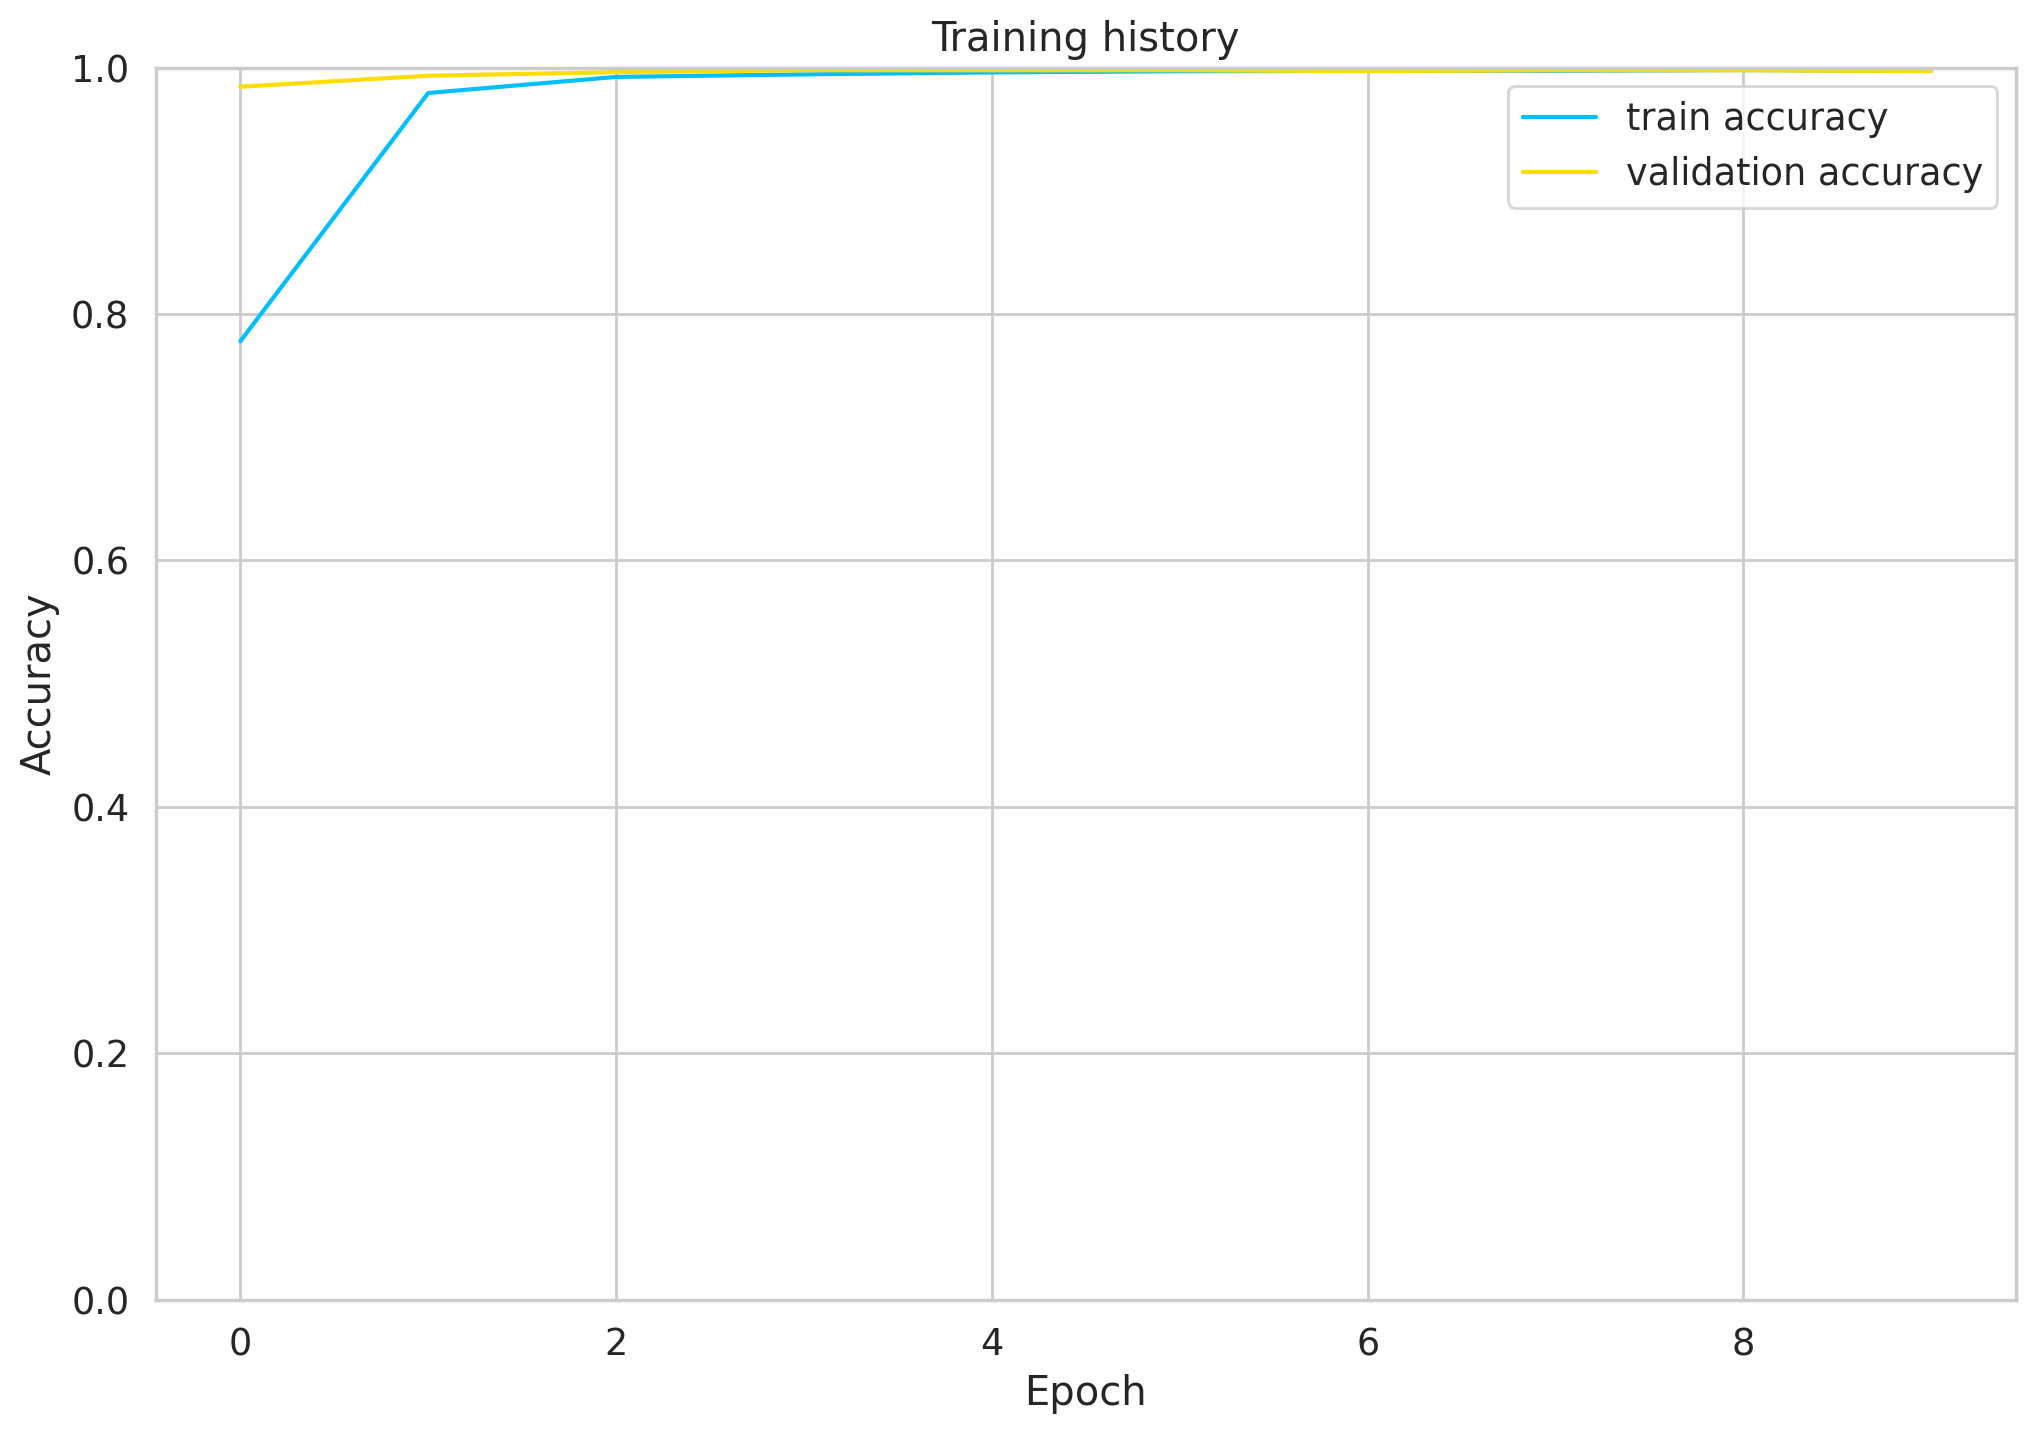

In [35]:
plt.plot([i.cpu() for i in history['train_acc']], label='train accuracy')
plt.plot([i.cpu() for i in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

檢視最後的testing結果

In [36]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(book_test)
)

print(f"accuracy of test data: {test_acc.item()}")

/tmp/ipykernel_1030976/3244882329.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(outputs)


accuracy of test data: 0.9962852897473996
